In [1]:
pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 29.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 11.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb 


from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

s3= boto3.resource('s3')
bucket_name= 'morgan-gant-data448-bucket'
bucket= s3.Bucket(bucket_name)

file_key= 'MarketingData.csv'

bucket_object= bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

#reading the datefile
market = pd.read_csv(file_content_stream)
market.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel
0,6623.613537,5513.093240,6019.057354,5669.568008,5898.660607,5179.234947,2
1,5642.542497,5829.866565,3960.339943,4270.020548,3498.818262,4327.423268,2
2,5292.078175,6634.370556,4444.335138,4888.286021,3265.391352,4887.560190,2
3,5595.227928,4754.860698,2977.856511,3462.490957,3609.264559,4268.641413,0
4,5126.693267,6009.649079,3811.569943,4744.115976,3829.516831,5097.491872,2


In [29]:
market['Channel'].value_counts()/market.shape[0]
#Number of observations in each category is pretty close to even but I'm going to use stratify to make sure they are represented accurately in the split!

0    0.25035
3    0.25010
1    0.25005
2    0.24950
Name: Channel, dtype: float64

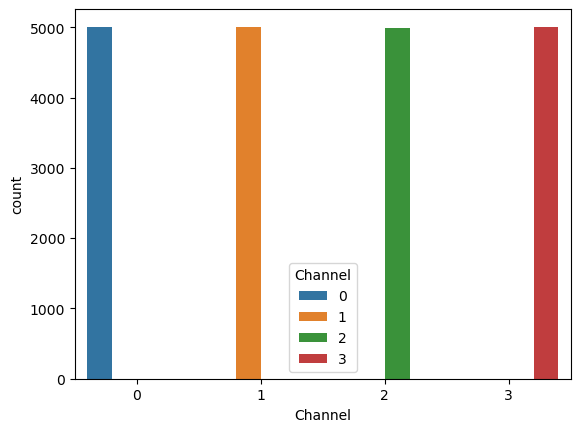

In [31]:
#Number of observations
sns.countplot(x = 'Channel', hue = 'Channel', data = market);
#As you can see from the chart and frequency statistics, the data is very close to balanced

<AxesSubplot: xlabel='Channel', ylabel='Delicassen'>

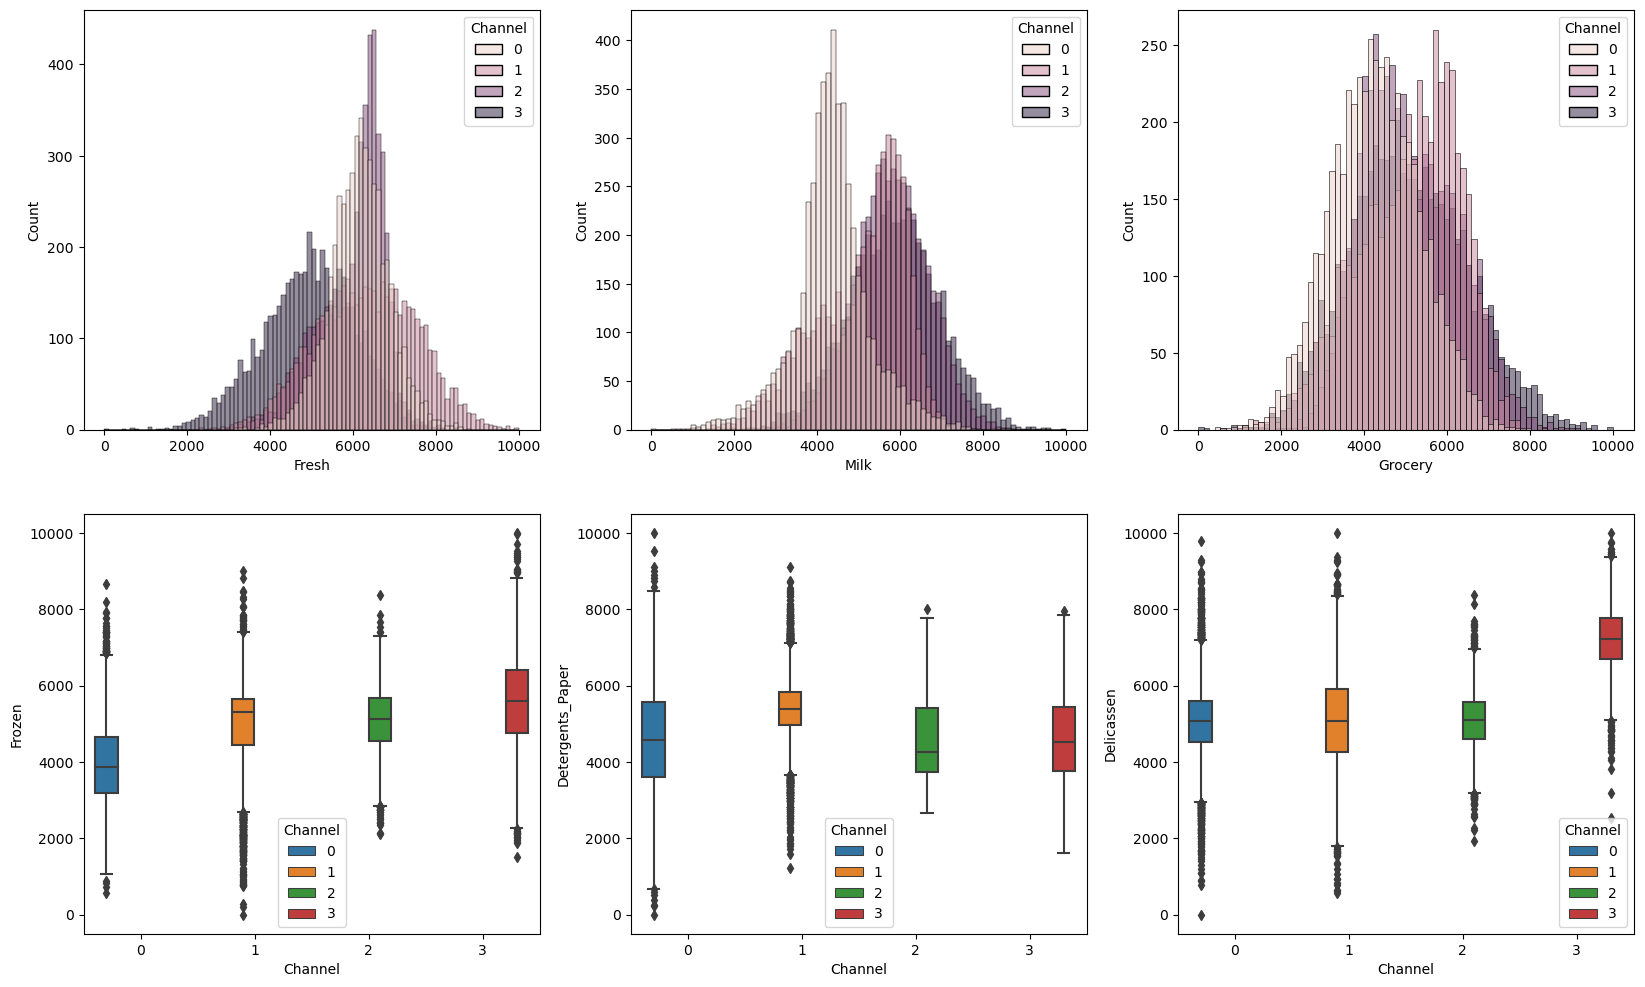

In [35]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))
sns.histplot(ax = axes[0, 0], x = 'Fresh', hue = 'Channel', fill = True, data = market)
sns.histplot(ax = axes[0, 1], x = 'Milk', hue = 'Channel', fill = True, data = market)
sns.histplot(ax = axes[0, 2], x = 'Grocery', hue = 'Channel', fill = True, data = market)
sns.boxplot(ax = axes[1, 0], x = 'Channel', y = 'Frozen', hue = 'Channel', data = market)
sns.boxplot(ax = axes[1, 1], x = 'Channel', y = 'Detergents_Paper', hue = 'Channel', data = market)
sns.boxplot(ax = axes[1, 2], x = 'Channel', y = 'Delicassen', hue = 'Channel', data = market)

#fig 1--> You can see there are lower charges in category channel 3's comapred to the others, where they have a large spike in products between 5000 and 8000
#fig 2--> There is a seperation between milk in channel 0 and the other channels, Channel 0 has the higher average purchases. 
#fig 3--> Looks to almost have a normal shape when all 4 channels are considered (Close to avergae spending for each one)
#fig 4 --> looks like not as many frozen items are in channel 0 when compared to the other 3 channels
#fig 5--> There is a small range in medians from each channel along with outliers when looking at detergents and paper
#fig 6--> More money is spent on Delicassen items, on avergae, that are in channel 3 more than any other channel

In [19]:
#Defining input and target variables
x = market.drop(columns=['Channel'], axis=1)
y= market['Channel']

#Splitting the data
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify=y)

In [5]:
x.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,6623.613537,5513.093240,6019.057354,5669.568008,5898.660607,5179.234947
1,5642.542497,5829.866565,3960.339943,4270.020548,3498.818262,4327.423268
2,5292.078175,6634.370556,4444.335138,4888.286021,3265.391352,4887.560190
3,5595.227928,4754.860698,2977.856511,3462.490957,3609.264559,4268.641413
4,5126.693267,6009.649079,3811.569943,4744.115976,3829.516831,5097.491872


In [15]:
#Scaling the data
#scaler= MinMaxScaler()
#x_train= scaler.fit_transform(x_train)
#x_test= scaler.fit_transform(x_test)

XGBOOST 1 vs Rest

In [20]:
#Building model
one_vs_all_xgb= OneVsRestClassifier(estimator= xgb.XGBClassifier(max_depth= 3, n_estimators= 500, learning_rate= .01 )).fit(x_train, y_train)

#Predicting on the test
one_vs_all_xgb_pred= one_vs_all_xgb.predict_proba(x_test)
one_vs_all_xgb_pred= np.argmax(one_vs_all_xgb_pred, axis=1) + 1

print(confusion_matrix(y_test, one_vs_all_xgb_pred))
print(classification_report(y_test, one_vs_all_xgb_pred))

[[  0 803 100  45  53]
 [  0  59 709 112 120]
 [  0 104  23 825  46]
 [  0  42  42  43 874]
 [  0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1001
           1       0.06      0.06      0.06      1000
           2       0.03      0.02      0.02       998
           3       0.04      0.04      0.04      1001
           4       0.00      0.00      0.00         0

    accuracy                           0.03      4000
   macro avg       0.03      0.03      0.03      4000
weighted avg       0.03      0.03      0.03      4000



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

Test --> Random Forest

In [27]:
#Building model
one_vs_all_rf= OneVsRestClassifier(estimator= RandomForestClassifier(n_estimators=500, max_depth= 3)).fit(x_train, y_train)

#Predicting on the test
one_vs_all_rf_pred= one_vs_all_rf.predict_proba(x_test)
one_vs_all_rf_pred= np.argmax(one_vs_all_rf_pred, axis=1)+1

print(confusion_matrix(y_test, one_vs_all_rf_pred))
print(classification_report(y_test, one_vs_all_rf_pred))

[[  0 726 117  99  59]
 [  0  81 606 167 146]
 [  0 128  28 797  45]
 [  0  48  26  60 867]
 [  0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1001
           1       0.08      0.08      0.08      1000
           2       0.04      0.03      0.03       998
           3       0.05      0.06      0.06      1001
           4       0.00      0.00      0.00         0

    accuracy                           0.04      4000
   macro avg       0.03      0.03      0.03      4000
weighted avg       0.04      0.04      0.04      4000



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

Test --> Decision Tree

In [26]:
#Building model
one_vs_all_dt= OneVsRestClassifier(estimator= DecisionTreeClassifier(max_depth=3)).fit(x_train, y_train)

#Predicting on the test
one_vs_all_dt_pred= one_vs_all_dt.predict_proba(x_test)
one_vs_all_dt_pred= np.argmax(one_vs_all_dt_pred, axis=1) + 1

print(confusion_matrix(y_test, one_vs_all_dt_pred))
print(classification_report(y_test, one_vs_all_dt_pred))

[[  0 686 120  95 100]
 [  0  84 720  38 158]
 [  0 133 252 569  44]
 [  0  33  26  63 879]
 [  0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1001
           1       0.09      0.08      0.09      1000
           2       0.23      0.25      0.24       998
           3       0.08      0.06      0.07      1001
           4       0.00      0.00      0.00         0

    accuracy                           0.10      4000
   macro avg       0.08      0.08      0.08      4000
weighted avg       0.10      0.10      0.10      4000



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

XGBOOST 1 vs 1

In [22]:
#Building model
one_vs_one_xgb= OneVsOneClassifier(estimator= xgb.XGBClassifier(max_depth= 3, n_estimators= 500, learning_rate= .01 )).fit(x_train, y_train)

#Predicting on the test
one_vs_one_xgb_pred= one_vs_one_xgb.predict(x_test)

print(confusion_matrix(y_test, one_vs_one_xgb_pred))
print(classification_report(y_test, one_vs_one_xgb_pred))

[[818  89  39  55]
 [ 42 725 115 118]
 [ 73  24 864  37]
 [ 39  49  33 880]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1001
           1       0.82      0.72      0.77      1000
           2       0.82      0.87      0.84       998
           3       0.81      0.88      0.84      1001

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



In [ ]:
#When I ran OneVsRest with an XGBoost model, the results were so low. I thought I did something wrong so I tested it out on two other models 
    #(Random Forest and Decision Trees) and the results were still very low. So for the split I was delt, I would continue with an XGBoost Model 
    #using the OneVsOne Classifier to help determine what channel goods should be assigned to. 
#Note: The results of the XGBoost OneVsOne weren't super good but weren't bad either. They were in the 80% range for almost all tests.
        #To determine if this is good enough we would need to talk to the company to see what thier standards are for the model. 